In [1]:
%load_ext autoreload
%autoreload 2

In [2]:
%matplotlib inline
import cmocean
from matplotlib import pyplot as plt

In [3]:
import os
import pathlib
import sys
from subprocess import call

In [4]:
from datetime import datetime, timedelta

In [5]:
import numpy as np
import pandas as pd
import xarray as xr

In [6]:
sys.path.append("../code/")

In [7]:
import src

### parameters for papermill 

In [8]:
domain = "NZ"
ipath = "/media/nicolasf/END19101/data/OISST/daily"
clim_path = "/home/nicolasf/operational/OISST_indices/outputs/"
fig_path = "/home/nicolasf/operational/OISST_indices/figures/"
ndays_agg = 1
ndays_back = 365 * 10
quantile = .9
lag = 0

### get the pathlib paths for the data and the climatology 

In [10]:
ipath = pathlib.Path(ipath).joinpath(domain)
clim_path = pathlib.Path(clim_path).joinpath(domain)
fig_path = pathlib.Path(fig_path)

### get the current date 

In [11]:
current_date = datetime.utcnow()

### get the first day of the period to extract 

In [12]:
first_day = current_date - timedelta(days=ndays_back)

## get the years to read 

In [13]:
years_to_get = np.unique(np.arange(first_day.year, current_date.year + 1))

In [14]:
lfiles = [ipath.joinpath(f"sst.day.mean.{year}.v2.nc") for year in years_to_get]

In [15]:
lfiles.sort()

In [16]:
lfiles[0]

PosixPath('/media/nicolasf/END19101/data/OISST/daily/NZ/sst.day.mean.2012.v2.nc')

In [17]:
lfiles[-1]

PosixPath('/media/nicolasf/END19101/data/OISST/daily/NZ/sst.day.mean.2022.v2.nc')

## opens the near realtime dataset 

In [18]:
dset = xr.open_mfdataset(lfiles, parallel=True, combine="by_coords", engine='netcdf4') 

In [19]:
dset

<xarray.Dataset>
Dimensions:  (time: 3931, lat: 80, lon: 72)
Coordinates:
  * time     (time) datetime64[ns] 2012-01-01 2012-01-02 ... 2022-10-05
  * lat      (lat) float32 -49.88 -49.62 -49.38 -49.12 ... -30.62 -30.38 -30.12
  * lon      (lon) float32 162.1 162.4 162.6 162.9 ... 179.1 179.4 179.6 179.9
Data variables:
    sst      (time, lat, lon) float32 dask.array<chunksize=(366, 80, 72), meta=np.ndarray>

### calculates the rolling averages here if the number of days > 1

In [20]:
if ndays_agg > 1:

    dset = dset.rolling({"time": ndays_agg}, min_periods=ndays_agg, center=False).mean(
        "time"
    )

    dset = dset.isel(time=slice(ndays_agg + 1, None))

### first and last day in the dataset 

In [21]:
first_day = pd.to_datetime(dset.time.data[0])
last_day = pd.to_datetime(dset.time.data[-1])

### get rid of the 29th of Feb if present 

In [22]:
dset = dset.convert_calendar("noleap")

### opens the climatology 

In [23]:
clim = xr.open_zarr(
    clim_path.joinpath(f"{domain}_OISST_{ndays_agg}days_climatology_15_window.zarr")
)

In [24]:
clim

<xarray.Dataset>
Dimensions:    (lat: 80, lon: 72, dayofyear: 365, quantile: 7)
Coordinates:
  * dayofyear  (dayofyear) int64 1 2 3 4 5 6 7 8 ... 359 360 361 362 363 364 365
  * lat        (lat) float32 -49.88 -49.62 -49.38 ... -30.62 -30.38 -30.12
  * lon        (lon) float32 162.1 162.4 162.6 162.9 ... 179.1 179.4 179.6 179.9
  * quantile   (quantile) float64 0.01 0.1 0.25 0.5 0.75 0.9 0.99
Data variables:
    average    (lat, lon, dayofyear) float32 dask.array<chunksize=(20, 36, 183), meta=np.ndarray>
    quantiles  (dayofyear, quantile, lat, lon) float64 dask.array<chunksize=(92, 2, 20, 36), meta=np.ndarray>
    std        (lat, lon, dayofyear) float32 dask.array<chunksize=(20, 36, 183), meta=np.ndarray>

### calculate the anomalies with respect to the 1991-2020 average

In [25]:
anoms = dset.groupby(dset.time.dt.dayofyear) - clim["average"]

/home/nicolasf/mambaforge/envs/OISST/lib/python3.8/site-packages/xarray/core/indexing.py:1374: PerformanceWarning: Slicing with an out-of-order index is generating 11 times more chunks
  return self.array[key]


### repeat the climatology over the time dimension 

In [26]:
clim_repeat = clim.sel(dayofyear=dset.time.dt.dayofyear)

/home/nicolasf/mambaforge/envs/OISST/lib/python3.8/site-packages/xarray/core/indexing.py:1374: PerformanceWarning: Slicing with an out-of-order index is generating 11 times more chunks
  return self.array[key]


In [27]:
clim_repeat

<xarray.Dataset>
Dimensions:    (lat: 80, lon: 72, time: 3928, quantile: 7)
Coordinates:
    dayofyear  (time) int64 1 2 3 4 5 6 7 8 ... 271 272 273 274 275 276 277 278
  * lat        (lat) float32 -49.88 -49.62 -49.38 ... -30.62 -30.38 -30.12
  * lon        (lon) float32 162.1 162.4 162.6 162.9 ... 179.1 179.4 179.6 179.9
  * quantile   (quantile) float64 0.01 0.1 0.25 0.5 0.75 0.9 0.99
  * time       (time) object 2012-01-01 00:00:00 ... 2022-10-05 00:00:00
Data variables:
    average    (lat, lon, time) float32 dask.array<chunksize=(20, 36, 183), meta=np.ndarray>
    quantiles  (time, quantile, lat, lon) float64 dask.array<chunksize=(92, 2, 20, 36), meta=np.ndarray>
    std        (lat, lon, time) float32 dask.array<chunksize=(20, 36, 183), meta=np.ndarray>

### derive the mask highlighting MHW conditions

In [28]:
mask = dset["sst"].where(dset["sst"] >= clim_repeat["quantiles"].sel(quantile=quantile))
mask = mask.where(np.isnan(mask), other=1)

### Now select the maps to plot 

In [29]:
dataarray_anoms = anoms.isel(time=(-lag - 1))["sst"]

In [30]:
dataarray_raw = dset.isel(time=(-lag - 1))["sst"]

In [31]:
dataarray_mask = mask.isel(time=(-lag - 1))

### Interpolate over the missing (land) grid points, for smooth plotting 

In [32]:
dataarray_anoms = src.interpolate_NaN_da(dataarray_anoms)

In [33]:
dataarray_raw = src.interpolate_NaN_da(dataarray_raw)

In [34]:
cmap = cmocean.cm.balance

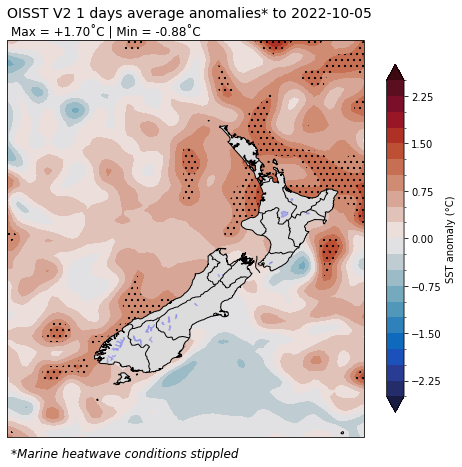

In [35]:
f, ax = src.plot_SST_map(
    dataarray_anoms,
    dataarray_mask,
    ndays_agg=ndays_agg,
    levels=np.arange(-2.5, 2.5 + 0.25, 0.25),
)

In [36]:
f.savefig(
    fig_path.joinpath(f"proto_OISST_anoms_{ndays_agg:02d}_days.png"),
    dpi=200,
    bbox_inches="tight",
    facecolor="w",
)

### Now calculates the number of heatwaves periods (consecutive periods to date > 90th percentile) 

In [37]:
heatwaves_days = mask.copy()

In [38]:
heatwaves_days = heatwaves_days.fillna(0)

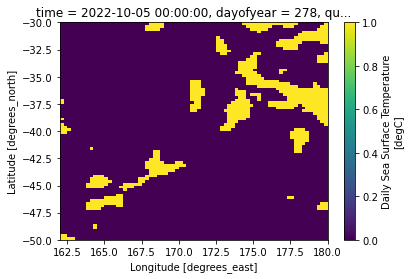

In [39]:
heatwaves_days[-1, :, :].plot()

In [40]:
heatwaves_days = 1 - heatwaves_days

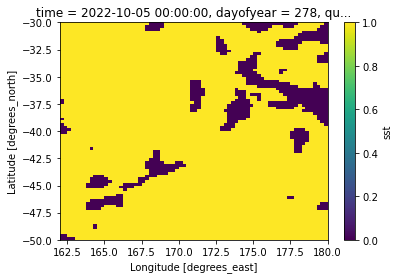

In [41]:
heatwaves_days[-1, :, :].plot()

In [42]:
heatwaves_days_consecutive = heatwaves_days.cumsum(dim="time", keep_attrs=True)

In [43]:
heatwaves_days_consecutive["time"] = (
    ("time"),
    np.arange(len(heatwaves_days.time))[::-1],
)

In [44]:
heatwaves_days_consecutive = heatwaves_days_consecutive.idxmax(dim="time")

In [45]:
heatwaves_days_consecutive

<xarray.DataArray 'time' (lat: 80, lon: 72)>
dask.array<where, shape=(80, 72), dtype=float64, chunksize=(10, 36), chunktype=numpy.ndarray>
Coordinates:
  * lat       (lat) float32 -49.88 -49.62 -49.38 -49.12 ... -30.62 -30.38 -30.12
  * lon       (lon) float32 162.1 162.4 162.6 162.9 ... 179.1 179.4 179.6 179.9
    quantile  float64 0.9

In [46]:
import palettable

In [47]:
cmap = palettable.scientific.sequential.Bilbao_20.mpl_colormap

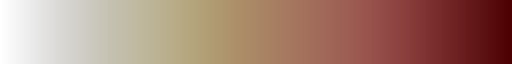

In [48]:
cmap

In [49]:
import cartopy.feature as cfeature

states_provinces = cfeature.NaturalEarthFeature(
    category="cultural",
    name="admin_1_states_provinces_lines",
    scale="10m",
    facecolor="none",
)

lakes = cfeature.NaturalEarthFeature("physical", "lakes", "10m")
land = cfeature.NaturalEarthFeature("physical", "land", "10m")

In [50]:
from cartopy import crs as ccrs

In [51]:
cbar_kwargs = {"shrink": 0.8, "label": "nb. of periods"}

Text(0.5, 1.0, 'OISST V2 1 day(s) to 2022-10-05\nNumber of consecutive 1 day(s) periods\nabove 90th percentile')

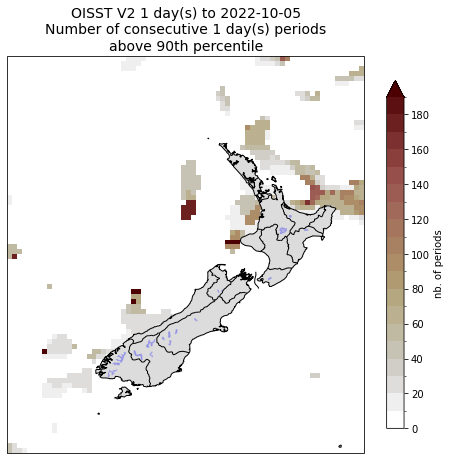

In [52]:
f, ax = plt.subplots(
    figsize=(8, 8),
    subplot_kw=dict(projection=ccrs.PlateCarree(central_longitude=180)),
)

heatwaves_days_consecutive.plot(
    ax=ax,
    levels=np.arange(0, 200, 10),
    transform=ccrs.PlateCarree(),
    cmap=cmap,
    cbar_kwargs=cbar_kwargs,
)

ax.add_feature(land, facecolor="gainsboro")
ax.add_feature(lakes, facecolor="b", edgecolor="b", alpha=0.2)
ax.add_feature(states_provinces, edgecolor="k", linewidth=1)
ax.coastlines("10m", linewidth=1)

ax.set_title(
    f"OISST V2 {ndays_agg} day(s) to {last_day:%Y-%m-%d}\nNumber of consecutive {ndays_agg} day(s) periods\nabove {int(quantile*100):02d}th percentile",
    fontsize=14,
)

In [53]:
f.savefig(
    fig_path.joinpath(f"proto_OISST_heatwave_days_{ndays_agg:02d}_days.png"),
    dpi=200,
    bbox_inches="tight",
    facecolor="w",
)